<div class="alert alert-info">
    <h1 align="center">Machine Learning in Python</h1>
    <h3 align="center">Week 08: Artifitial Neural Networks in Python</h3>
    <h5 align="center"><a href="http://www.snrazavi.ir/ml-with-python">Seyed Naser RAZAVI</a></h5>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import layers
from data_utils import load_CIFAR10

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'spline16'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Non-Linear Classification

## Machine Learning Key Ingredients
Any machine learning algorithm is composed of **four key ingredients**: 
- **Data** (Trainig, Test, Validation)
- **Model** or algorithm (Linear, Logistic Regression, Neural Network, Support Vector Machine, etc.)
- **Loss function** (Cross-Enropy, multi-class SVM, SSE, etc.)
- **Optimization method** (Gradient Descent, Mini-batch Gradient Decsent, Adam, RMSprops, etc.)

## Objectives
Today, we will take a look at:
- Non-Linear Classification
- Activation functions (sigmoid, tanh, relu)
- Artificial Neural Networks (ANNs)

## CIFAR-10 Data Loading and Preprocessing

In [2]:
from data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape:   ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:       ', X_test.shape)
print('Test labels shape:     ', y_test.shape)

Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:        (10000, 32, 32, 3)
Test labels shape:      (10000,)


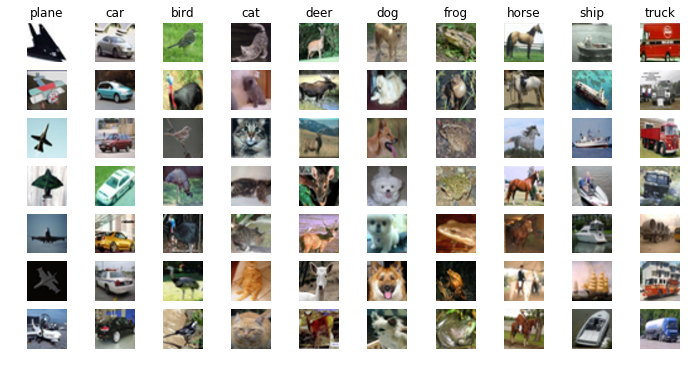

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)

Train data shape:         (49000, 32, 32, 3)
Train labels shape:       (49000,)
Validation data shape:    (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:          (1000, 32, 32, 3)
Test labels shape:        (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val   = np.reshape(X_val, (X_val.shape[0], -1))
X_test  = np.reshape(X_test, (X_test.shape[0], -1))
X_dev   = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


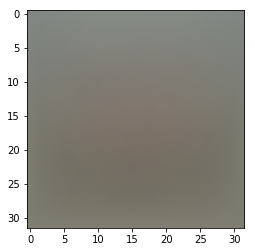

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image
X_dev   -= mean_image

## Parametric Classification
- In any parametric method, there are a **fixed set of parameters**.
- The goal of learning is to **determine the best possible values** for these parameters.
- After learning parameters from data, we can predict for new data **using only these parameters**.

## Non-Linear Score function
**before:**

$$f = Wx$$

**Now:** (2-Layer NN)

$$f = W_2 \max(0, W_1 x)$$

<img src="http://www.snrazavi.ir/imgs/8-1NN.jpg" width="50%">

**Or:** (3-Layer NN)

$$f = W_3 \max(0, W_2 \max(0, W_1 x))$$

<img src="http://www.snrazavi.ir/imgs/08-2-three-layer-NN.jpg" width="70%">

### Non-linearity (Activation function)
- The non-linear functions in hidden layers are very important.
- Without them, the neural network is nothing more than a linear score function.
- For example, whithout non-linear functions in a 2-hidden layer NN, we would have:

$$f = (W_3 \times W_2 \times W_1) x = W x$$

### Different Types of Activation Functions

In [8]:
x = np.linspace(-10, 10, 100)

# Sigmoid function
y1 = 1. / (1. + np.exp(-x))

# Tangent hyperbolic
y2 = np.tanh(x)

# ReLU
y3 = np.maximum(0, x)

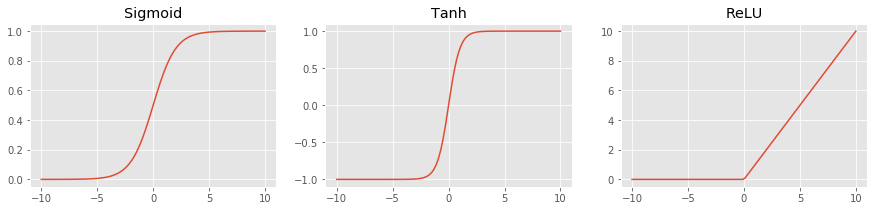

In [9]:
# plot activation functions
plt.style.use('ggplot')
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.plot(x, y1, label='sigmoid')
plt.title('Sigmoid')

plt.subplot(1, 3, 2)
plt.plot(x, y2, label='tanh')
plt.title('Tanh')

plt.subplot(1, 3, 3)
plt.plot(x, y3, label='ReLU')
plt.title('ReLU')

plt.show()

### Which activation function I should use?
- Today, in modern neural networks, the default is **ReLU**.
- It is strongly recommended to avoid using **sigmoid**.
- Sometimes, you can use **tanh**, but don't except to get any thing.

**Note.** Using ReLU, the training process will be 5 to 6 times faster. Please see [here](https://www.youtube.com/watch?v=MdDIVaM6AlA&index=3&list=PLW529xl11jnmEDQu-6knnSWCimisMNz_9).

### ReLU forward

```python
def relu_forward(x):
    """ Forward pass for a layer of rectified linear units.
    """
    cache = x
    out = np.maximum(0, x)
    return out, cache
```

### ReLU backward

```python
def relu_backward(dout, cache):
    """ Backward pass for a layer of rectified linear units.
    """
    x = cache
    dx = dout * (x > 0)
    return dx
```

### Sandwich layers
Consider the architecture of a traditional neural net:

- **2-Layer:** Input -> Hidden -> Output
- **3-Layer:** Input -> Hidden1 -> Hidden2 -> Output

In hidden layers, we first apply an affine layer and then a relu non-linearity. We can combine these two layers, or any two consecutive layers, in one new layers.

```python
def affine_relu_forward(x, w, b):
    """An affine layer and the a relu forward"""
    pass
    
    
def affine_relu_backward(dout, cache):
    """An affine layer and the a relu forward"""
    pass
```

In [10]:
from layers import affine_forward, affine_backward
from layers import relu_forward, relu_backward

In [11]:
def affine_relu_forward(x, w, b):
    out, cache_a = affine_forward(x, w, b)
    out, cache_r = relu_forward(out)
    return out, (cache_a, cache_r)

In [12]:
def affine_relu_backward(dout, cache):
    cache_a, cache_r = cache
    dout = relu_backward(dout, cache_r)
    dx, dw, db = affine_backward(dout, cache_a)
    return dx, dw, db

## Implementing a 2-Layer Neural Network

1. Input layer
2. Hidden layer: affine-relu
3. Outpit layer: affine

In [13]:
from layers import softmax_loss

def two_layer_network_loss(X, y, params):
    W1, b1 = params['W1'], params['b1']    
    W2, b2 = params['W2'], params['b2']
    
    # forward step
    h, cache_h = affine_relu_forward(X, W1, b1)  # hidden layer
    scores, cache_o = affine_forward(h, W2, b2)  # output layer
    
    # compute data loss
    loss, dscores = softmax_loss(scores, y)
       
    # Backward step
    dh, dW2, db2 = affine_backward(dscores, cache_o)  # output layer
    _, dW1, db1 = affine_relu_backward(dh, cache_h)   # hidden layer
       
    grads = {
        'W1': dW1, 
        'b1': db1, 
        'W2': dW2, 
        'b2': db2
    }
    
    return loss, grads

In [14]:
def predict(X, params):
    W1, b1 = params['W1'], params['b1']    
    W2, b2 = params['W2'], params['b2']
    
    h, _ = affine_relu_forward(X, W1, b1)  # hidden layer
    scores, _ = affine_forward(h, W2, b2)  # output layer
    
    return np.argmax(scores, axis=1)

In [15]:
def accuracy(y_pred, y_true):
    return 100.0 * np.mean(y_pred == y_true)

# Putting All Together: Data + Model + Loss + Optimization

## Data: `CIFAR-10`
- Our data is ready, as we have done all necessary pre-processing steps.

In [16]:
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


## Model: `1-hidden layer neural network`
- for data $(x_i, y_i)$, compute the score using: 

$$f = W_2 \max(0, W_1 x_i + b_1) + b_2$$

## Loss function: `Cross-Enropy`
- From score, compute probabilities using `softmax` function.
- Compute loss for each data using the computed probilities and its true label.

$$L_i=-\log(p_{y_i})$$

- Compute the total loss as the average over all the data losses plus regularization loss.

$$L = \frac{1}{N} \sum_{i=1}^N{L_i} + \lambda \sum_{jk}W_{jk}^2$$

**Note**: Remember to use *vectorized implementation*, which is computationally much more efficient.

## Minimize Loss Function: `Gradient Descent`

#### Initialize neural network weights

In [17]:
n_inputs  = 3072
n_hiddens = 100
n_classes = 10

# initialize parameters
params = {}
params['W1'] = 0.0001 * np.random.randn(n_inputs, n_hiddens)
params['b1'] = np.zeros((n_hiddens,))
params['W2'] = 0.0001 * np.random.randn(n_hiddens, n_classes)
params['b2'] = np.zeros((n_classes))

#### Gradient descent

In [18]:
N = X_train.shape[0]

# hyper-parameters
n_iterations = 2000
batch_size = 256
lr = 1e-3
reg = 1e-2

loss_history = []

for i in range(n_iterations + 1):
    # create a batch of training data
    idx = np.random.choice(N, batch_size, replace=False)
    X_batch, y_batch = X_train[idx], y_train[idx]
    
    loss, grads = two_layer_network_loss(X_batch, y_batch, params)  # data loss
    loss += 0.5 * reg * (np.sum(params['W1'] * params['W1']) + 
                         np.sum(params['W2'] * params['W2']))       # reg. loss
    
    loss_history.append(loss)
    
    # report every 100 iterations
    if i % 100 == 0:
        y_train_pred = predict(X_batch, params)
        train_acc = accuracy(y_train_pred, y_batch)
        
        y_val_pred = predict(X_val, params)
        val_acc = accuracy(y_val_pred, y_val)
        
        print("%4d: loss = %.2f | train accuracy = %5.2f | validation accuracy = %5.2f" % 
              (i, loss, train_acc, val_acc))
    
    grads['W1'] += reg * params['W1']
    grads['W2'] += reg * params['W2']

    # update parameters
    params['W1'] -= lr * grads['W1']
    params['b1'] -= lr * grads['b1']
    params['W2'] -= lr * grads['W2']
    params['b2'] -= lr * grads['b2']

   0: loss = 2.30 | train accuracy =  8.59 | validation accuracy =  9.90
 100: loss = 1.89 | train accuracy = 32.03 | validation accuracy = 30.00
 200: loss = 1.83 | train accuracy = 34.77 | validation accuracy = 37.60
 300: loss = 1.66 | train accuracy = 38.67 | validation accuracy = 42.30
 400: loss = 1.67 | train accuracy = 44.14 | validation accuracy = 43.70
 500: loss = 1.48 | train accuracy = 46.88 | validation accuracy = 47.50
 600: loss = 1.57 | train accuracy = 44.92 | validation accuracy = 47.20
 700: loss = 1.51 | train accuracy = 45.70 | validation accuracy = 48.40
 800: loss = 1.50 | train accuracy = 45.31 | validation accuracy = 48.00
 900: loss = 1.50 | train accuracy = 46.48 | validation accuracy = 45.90
1000: loss = 1.27 | train accuracy = 52.34 | validation accuracy = 48.20
1100: loss = 1.48 | train accuracy = 49.22 | validation accuracy = 49.60
1200: loss = 1.29 | train accuracy = 55.86 | validation accuracy = 50.10
1300: loss = 1.33 | train accuracy = 50.39 | valida

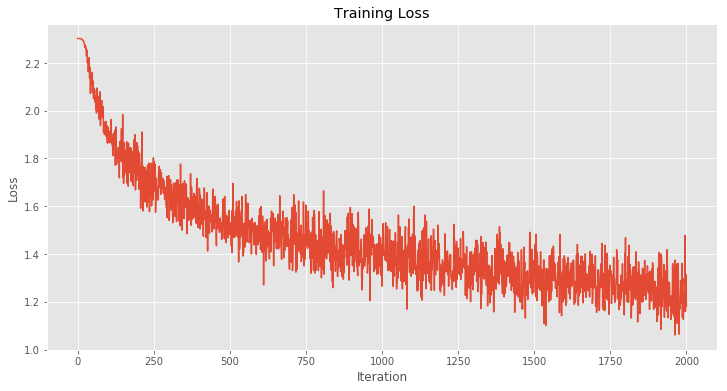

In [19]:
plt.style.use('ggplot')

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss');

### Prediction on test data

In [ ]:
test_pred = predict(X_test, params)
test_accuracy = accuracy(test_pred, y_test)
print("Test accuracy = %.2f" % test_accuracy)

#### Predict labels for 10 randomly chosen test data

In [ ]:
# choose 10 random test data
num_samples = 10
idxs = np.random.choice(X_test.shape[0], num_samples, replace=False)
X_sample, y_sample = X_test[idxs], y_test[idxs]

# predict labels
y_pred = predict(X_sample, params)

# To draw the picture, we should add back the mean
X_sample += mean_image

for i in range(num_samples):
    x, y = X_sample[i, :], y_sample[i]
    x = x.reshape((32, 32, 3))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x.astype('uint8'))
    plt.axis('off')
    plt.title(classes[y_pred[i]]);

### Side note: OOP

```python
class two_layer_net:
    
    def __init__(self, n_inputs, n_hiddens, n_classes):
        """ Create weights and init them.
        """
        self.params = {}
        self.params['W1'] = 0.0001 * np.random.randn(n_inputs, n_hiddens)
        self.params['b1'] = np.zeros((n_hiddens,))
        self.params['W2'] = 0.0001 * np.random.randn(n_hiddens, n_classes)
        self.params['b2'] = np.zeros((n_classes,))
        
    def loss(self, X, y):
        """ Returns loss and gradients w.r.t. parameters
        """
        # ...
        
    def predict(self, X):
        """ Predict class labels for inputs X.
        """
        # ...
```

<div class="alert alert-success">
    <h2>How to improve accuracy?</h2>
    <ul>
        <li>Increase <b>size</b> of hidden layers.</li>
        <li>Increase <b>number</b> of hidden layers.</li>
        <li>Do you mean DEEP LEARNING?</li>
    </ul>
</div>

<div class="alert alert-success">
    <h3>Programming Assignment:</h3>
    <p>Use a 2-hidden and 3-hidden layer neural network for CIFAR-10.
    <ul>
        <li>Compute the best accuracy which you can get in each case.</li>
        <li>Is it more difficult to train a larger network? why?</li>
    </ul>
</div>

### Problem
- The larger the neural net is, the higher the chance of **overfitting**.
- So, we need other ways of **regularization**.
 - Next week, we will see **Dropout**, which is a recent strong way of regularization.
 - Also, we will take a look at **batch normalization** and **weight initialization**.

### Dropout

<img src="http://www.snrazavi.ir/imgs/8-4Dropout.jpg" width="75%"/>

### Batch normalization

<img src="http://www.snrazavi.ir/imgs/8-3Batch_normalization.jpg" width="75%"/>

For a complete introduction to dropout and batch normalization, please refer to my slides or videos.

## Other update rules

<img src="http://www.snrazavi.ir/imgs/8-2Different_update_rules.gif" width="50%"/>